In [1]:
!hostname

hnl1


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from makefilter import makefiltersos
from data import get_data_loader
from models import *
from losses import *
from utilities import *

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
import seaborn as sns

import numpy as np
from scipy.stats.stats import spearmanr
from scipy.signal import resample, sosfiltfilt
from sklearn.metrics import accuracy_score
import torch

torch.cuda.set_device(0)

# Loading

In [4]:
subject = 's59'
set_seed(subject)

epoch = 15000
aim2 = False
one_hot_cond = True

experiment_name = 'ddm-vae_%s_full5_choice_ddm_signed4' % subject
# experiment_name = 'ddm-vae_%s_uninformed_full5_choice_ddm' % subject

snr_labels_train = ['high', 'med', 'low']
cond = 'all'

high_cond = torch.tensor([1, 0, 0]).cuda()
med_cond = torch.tensor([0, 1, 0]).cuda()
low_cond = torch.tensor([0, 0, 1]).cuda()

snrlabels = ['high', 'med', 'low']
colors = ['b', 'g', 'r']
alpha = 0.5
z_dim = 32

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Random seed set as 42


In [5]:
vaeEEG = EEGVAE(cond_addition=False).to(device)
posteriorDDM = PosteriorDDM().to(device)
bridgerDDM = BridgerDDM().to(device)
bridgerEEG = BridgerEEG().to(device)

saved_path = "saved_models/%s/ddmvae_%s.pth" % (experiment_name, epoch)

print(saved_path)

checkpoint = torch.load(saved_path)

vaeEEG.load_state_dict(checkpoint['vae_state_dict'])
posteriorDDM.load_state_dict(checkpoint['posterior_ddm_state_dict'])
bridgerDDM.load_state_dict(checkpoint['bridger_ddm_state_dict'])
bridgerEEG.load_state_dict(checkpoint['bridger_eeg_state_dict'])

vaeEEG.eval()
posteriorDDM.eval()
bridgerDDM.eval()
bridgerEEG.eval()

saved_models/ddm-vae_s59_full5_choice_ddm_signed4/ddmvae_15000.pth


BridgerEEG(
  (netE): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (fc): Linear(in_features=131, out_features=64, bias=True)
)

In [6]:
data_dir = 'dataset/'
train_dataloader, test_dataloader = get_data_loader('data_loaders/%s' %data_dir, batch_size=64, device=device, subject=subject,
                                                     shuffle_training=True,
                                                     shuffle_testing=True,
                                                     one_hot_cond=one_hot_cond)

data_loaders/dataset_cue/v0_val_s59_high.npy
v0 (223, 98)
eeg (223, 98, 250)
rt (223,)
data_loaders/dataset_cue/v0_train_s59_high.npy
v0 (889, 98)
eeg (889, 98, 250)
rt (889,)
data_loaders/dataset_cue/v0_val_s59_med.npy
v0 (222, 98)
eeg (222, 98, 250)
rt (222,)
data_loaders/dataset_cue/v0_train_s59_med.npy
v0 (885, 98)
eeg (885, 98, 250)
rt (885,)
data_loaders/dataset_cue/v0_val_s59_low.npy
v0 (223, 98)
eeg (223, 98, 250)
rt (223,)
data_loaders/dataset_cue/v0_train_s59_low.npy
v0 (890, 98)
eeg (890, 98, 250)
rt (890,)
v0_sub.shape torch.Size([2664, 98])
eeg_sub.shape torch.Size([2664, 98, 250])
rt_sub.shape torch.Size([2664])
conds_sub.shape torch.Size([2664, 3])
priors_sub.shape torch.Size([2664, 6])
v0_sub.shape torch.Size([668, 98])
eeg_sub.shape torch.Size([668, 98, 250])
rt_sub.shape torch.Size([668])
conds_sub.shape torch.Size([668, 3])
priors_sub.shape torch.Size([668, 6])


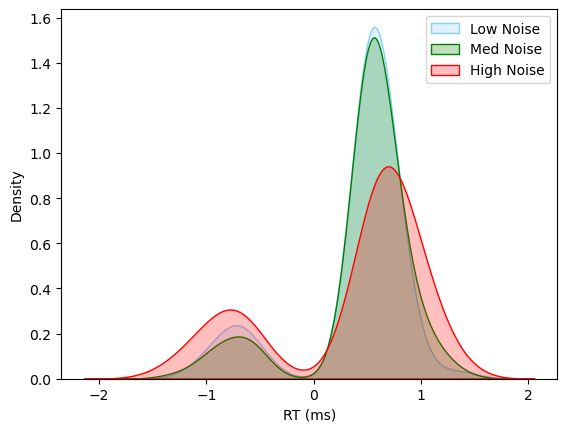

In [7]:
fig_name = '%s/%s/%s.png' % (subject, cond, 'rt_dist_test')

rts_high, rts_med, rts_low = get_rts_cond(
    test_dataloader, high_cond, med_cond, low_cond, device)
plot_rt_dist(rts_high, rts_med, rts_low, fig_name)

# from EEG Functions

In [8]:
def reconstruct_eeg(dataloader, cond_of_interest=None):
    
    eeg_rec_arr = []
    eeg_arr = []
    
    for batch in dataloader:
        eeg, rts, conds = torch.unsqueeze(batch[1].to(device), 1), \
            torch.unsqueeze(batch[2].to(device), 1), torch.unsqueeze(batch[3].to(device), 1)
        # rts = torch.abs(rts)
        # rt_idx = torch.squeeze(rts > 0)
        # v0, eeg, rts, conds = v0[rt_idx], eeg[rt_idx], rts[rt_idx], conds[rt_idx]

        if cond_of_interest is not None:
            cond_idx = get_cond_idx(conds, cond_of_interest)
            eeg, rts, conds = eeg[cond_idx], rts[cond_idx], conds[cond_idx]

        qX = vaeEEG.encoderX(eeg, conds)
        q_v, q_a, q_ndt, _ = posteriorDDM(eeg, conds)
        q_meanX, q_logvarX = qX[:, :z_dim], qX[:, z_dim:]
        
        q_mean_v, q_logvar_v = q_v[:, :1], q_v[:, 1:]
        q_mean_a, q_logvar_a = q_a[:, :1], q_a[:, 1:]
        q_mean_ndt, q_logvar_ndt = q_ndt[:, :1], q_ndt[:, 1:]
        q_mean_ddm = torch.cat([q_mean_v, q_mean_a, q_mean_ndt], dim=1)
        q_logvar_ddm = torch.cat([q_logvar_v, q_logvar_a, q_logvar_ndt], dim=1)
        
        eeg_rec, _, _ = vaeEEG.decoderX(q_meanX, q_mean_ddm, conds)
        eeg_rec_arr.append(torch.squeeze(eeg_rec).detach().cpu())
        
        eeg_arr.append(torch.squeeze(eeg).detach().cpu())

    eeg_arr = torch.cat(eeg_arr, axis=0).numpy()
    eeg_rec_arr = torch.cat(eeg_rec_arr, axis=0).numpy()

    return eeg_arr, eeg_rec_arr

# from RT Functions

In [59]:
def vary_ddm_params(dataloader, v=None, a=None, ndt=None, diff=False, cond_of_interest=None):

    res_argmin_rec = []
    res_min_rec = []
    eeg_rec_arr = []
    for batch in dataloader:
        v0, eeg, rts, conds = torch.unsqueeze(batch[0].to(device), 1), torch.unsqueeze(batch[1].to(device), 1), \
            torch.unsqueeze(batch[2].to(device), 1), torch.unsqueeze(batch[3].to(device), 1)
        # rts = torch.abs(rts)
        # rt_idx = torch.squeeze(rts > 0)
        # v0, eeg, rts, conds = v0[rt_idx], eeg[rt_idx], rts[rt_idx], conds[rt_idx]
        v0 = torch.unsqueeze(v0, -1).repeat((1, 1, 1, 250))
        
        if cond_of_interest is not None:
            num_gens = len(conds)
            conds = torch.stack([cond_of_interest] * num_gens).reshape(num_gens, 1, 3).float().cuda()

        q_ddm_rt = bridgerDDM(rts, conds)
        q_mean_ddm_rt, q_logvar_ddm_rt = q_ddm_rt[:, :3], q_ddm_rt[:, 3:]
                
        if not diff:
            q_mean_ddm_rt[:, 0] = v if v is not None else q_mean_ddm_rt[:, 0]
            q_mean_ddm_rt[:, 1] = a if a is not None else q_mean_ddm_rt[:, 1]
            q_mean_ddm_rt[:, 2] = ndt if ndt is not None else q_mean_ddm_rt[:, 2]
        else:
            # v_neg = q_mean_ddm_rt[:, 0][q_mean_ddm_rt[:, 0] < 0]
            # v_pos = q_mean_ddm_rt[:, 0][q_mean_ddm_rt[:, 0] >= 0]
            # v_neg = v_neg + v if v is not None else v_neg
            # v_pos = v_pos - v if v is not None else v_pos

            q_mean_ddm_rt[:, 0] = q_mean_ddm_rt[:, 0] + v if v is not None else q_mean_ddm_rt[:, 0]
            q_mean_ddm_rt[:, 1] = q_mean_ddm_rt[:, 1] + a if a is not None else q_mean_ddm_rt[:, 1]
            q_mean_ddm_rt[:, 2] = q_mean_ddm_rt[:, 2] + ndt if ndt is not None else q_mean_ddm_rt[:, 2]

        z_sample_ddm = latent_sample(q_mean_ddm_rt, q_logvar_ddm_rt)
        qX_rt = bridgerEEG(z_sample_ddm, conds)
        q_meanX_rt, q_logvarX_rt = qX_rt[:, :z_dim], qX_rt[:, z_dim:]
        z_sampleX = latent_sample(q_meanX_rt, q_logvarX_rt)

        eeg_rec, _, _ = vaeEEG.decoderX(z_sampleX, z_sample_ddm, conds)
        eeg_rec_arr.append(torch.squeeze(eeg_rec).detach().cpu())

        eeg_rec = torch.reshape(eeg_rec, (-1, 1, 98, 250))
        erp_rec = torch.sum(v0 * eeg_rec, dim=2)
        erp_rec = resample(erp_rec.squeeze(dim=1).cpu().detach().numpy(), 500, axis=-1)
        res_argmin_rec.append((np.argmin(erp_rec[:,int(250/2):int(375/2)], axis = 1) + 75) * 2)
        res_min_rec.append(np.abs(np.min(erp_rec[:,int(250/2):int(375/2)], axis = 1)))

    #     conds = torch.repeat_interleave(conds, num_samples, dim=0)
    #     q_mean_ddm_rt = torch.repeat_interleave(q_mean_ddm_rt, num_samples, dim=0)
    #     q_logvar_ddm_rt = torch.repeat_interleave(q_logvar_ddm_rt, num_samples, dim=0)
    #     z_sample_ddm = latent_sample(q_mean_ddm_rt, q_logvar_ddm_rt)
    #     qX_rt = bridgerEEG(z_sample_ddm, conds)
    #     q_meanX_rt, q_logvarX_rt = qX_rt[:, :z_dim], qX_rt[:, z_dim:]
    #     z_sampleX = latent_sample(q_meanX_rt, q_logvarX_rt)

    #     eeg_rec, _, _ = vaeEEG.decoderX(z_sampleX, z_sample_ddm, conds)
    #     eeg_rec = avg_n_rows(eeg_rec, num_samples, eeg_rec.shape[1])
    #     eeg_rec_arr.append(eeg_rec)

    #     eeg_rec = torch.tensor(np.reshape(eeg_rec, (-1, 1, 98, 250))).cuda()
    #     erp_rec = torch.sum(v0 * eeg_rec, dim=2)
    #     erp_rec = resample(erp_rec.squeeze(dim=1).cpu().detach().numpy(), 500, axis=-1)
    #     res_argmin_rec.append((np.argmin(erp_rec[:,int(250/2):int(375/2)], axis = 1) + 75) * 2)

    # return np.concatenate(res_argmin_rec), np.concatenate(eeg_rec_arr)

    return np.concatenate(res_argmin_rec), np.concatenate(res_min_rec), torch.cat(eeg_rec_arr, axis=0).numpy()

In [10]:
def bridger(rts, conds):
    q_ddm_rt = bridgerDDM(rts, conds)
    q_mean_ddm_rt, q_logvar_ddm_rt = q_ddm_rt[:, :3], q_ddm_rt[:, 3:]
    z_sample_ddm = latent_sample(q_mean_ddm_rt, q_logvar_ddm_rt)

    qX_rt = bridgerEEG(z_sample_ddm, conds)
    q_meanX_rt, q_logvarX_rt = qX_rt[:, :z_dim], qX_rt[:, z_dim:]

    return torch.cat([q_meanX_rt, q_mean_ddm_rt, q_logvarX_rt, q_logvar_ddm_rt], dim=1)

In [11]:
def get_ddm_n200_results_(dataloader, cond_of_interest, input_type, test_info=False, gen_dict=False):
    if input_type == 'eeg':
        num_samples = 1
        mean_sampled = False
    else:
        num_samples = 100 if gen_dict else 1
        mean_sampled = False

    res_logvar_ddm = []
    res_priors = []
    res_rts = []
    res_v = []
    res_a = []
    res_ndt = []
    res_argmin_ori = []
    res_argmin_rec = []
    
    res_min_ori = []
    res_min_rec = []
    
    res_erp_250Hz = []
    res_eeg_250Hz = []

    for batch in dataloader:
        v0, eeg, rts, conds, priors = torch.unsqueeze(batch[0].to(device), 1), torch.unsqueeze(batch[1].to(device), 1), \
    torch.unsqueeze(batch[2].to(device), 1), torch.unsqueeze(batch[3].to(device), 1), batch[4].to(device)
        # rts = torch.abs(rts)
        # rt_idx = torch.squeeze(rts > 0)
        # v0, eeg, rts, conds, priors = v0[rt_idx], eeg[rt_idx], rts[rt_idx], conds[rt_idx], priors[rt_idx]

        cond_idx = get_cond_idx(conds, cond_of_interest)
        
        v0, eeg, rts, conds, priors = v0[cond_idx], eeg[cond_idx], rts[cond_idx], conds[cond_idx], priors[cond_idx]
        
        if v0.shape[0] == 0:
            continue
        v0 = torch.unsqueeze(v0, -1).repeat((1, 1, 1, 250))
        
        erp = torch.sum(v0 * eeg, dim=2)

        if input_type == 'rt':
            encoding = bridger(rts, conds)
            q_mean, q_logvar = encoding[:, :z_dim + 3], encoding[:, z_dim + 3:]
            q_logvar_ddm_unique = q_logvar[:, -3:]
            
            q_mean = torch.repeat_interleave(q_mean, num_samples, dim=0)
            q_logvar = torch.repeat_interleave(q_logvar, num_samples, dim=0)

            q_meanX = q_mean[:, :-3]
            q_logvarX = q_logvar[:, :-3]
            q_mean_ddm = q_mean[:, -3:]
            q_logvar_ddm = q_logvar[:, -3:]

            choice = None

        else:
            encodingX = vaeEEG.encoderX(eeg, conds)

            # eeg_ = torch.repeat_interleave(eeg, num_samples, dim=0)
            # conds_ = torch.repeat_interleave(conds, num_samples, dim=0)
            # encoding_v, encoding_a, encoding_ndt, choice = posteriorDDM(eeg_, conds_)
            encoding_v, encoding_a, encoding_ndt, choice = posteriorDDM(eeg, conds)

            q_meanX, q_logvarX = encodingX[:, :z_dim], (encodingX[:, z_dim:])

            if test_info:
                z_sample_ddm = torch.cat([encoding_v[:, :1], encoding_a[:, :1], encoding_ndt[:, :1]], dim=1)
                eeg_rec_info, _, _ = vaeEEG.decoderX(q_meanX, z_sample_ddm, conds)
                encoding_v, encoding_a, encoding_ndt, _ = posteriorDDM(eeg_rec_info, conds)
                    
            q_mean_v, q_logvar_v = encoding_v[:, :1], encoding_v[:, 1:]
            q_mean_a, q_logvar_a = encoding_a[:, :1], encoding_a[:, 1:]
            q_mean_ndt, q_logvar_ndt = encoding_ndt[:, :1], encoding_ndt[:, 1:]
            q_mean_ddm = torch.cat([q_mean_v, q_mean_a, q_mean_ndt], dim=1)
            q_logvar_ddm_unique = torch.cat([q_logvar_v, q_logvar_a, q_logvar_ndt], dim=1)

            q_meanX = torch.repeat_interleave(q_meanX, num_samples, dim=0)
            q_logvarX = torch.repeat_interleave(q_logvarX, num_samples, dim=0)
            q_mean_ddm = torch.repeat_interleave(q_mean_ddm, num_samples, dim=0)
            q_logvar_ddm = torch.repeat_interleave(q_logvar_ddm_unique, num_samples, dim=0)
            
        if mean_sampled:
            z_sampleX = q_meanX
            z_sample_ddm = q_mean_ddm
        else:
            z_sampleX = latent_sample(q_meanX, q_logvarX)
            if gen_dict:
                z_sample_ddm = latent_sample(q_mean_ddm, q_logvar_ddm)
            else:
                z_sample_ddm = latent_sample(q_mean_ddm, q_logvar_ddm_unique)
        
        v, a, ndt = torch.unsqueeze(z_sample_ddm[:, -3], dim=1), torch.unsqueeze(z_sample_ddm[:, -2], dim=1), torch.unsqueeze(z_sample_ddm[:, -1], dim=1)

        conds = torch.repeat_interleave(conds, num_samples, dim=0)
        
        v = avg_n_rows(v, num_samples, v.shape[1])
        v = torch.tensor(v[:, np.newaxis]).cuda()
        if choice is not None:
            v = torch.mul(v, torch.sign(choice))

        a = avg_n_rows(a, num_samples, v.shape[1])
        a = torch.tensor(a[:, np.newaxis]).cuda()

        ndt = avg_n_rows(ndt, num_samples, v.shape[1])
        ndt = torch.tensor(ndt[:, np.newaxis]).cuda()

        # q_logvar_ddm_unique = avg_n_rows(q_logvar_ddm_unique, num_samples, 3)
        # q_logvar_ddm_unique = torch.tensor(q_logvar_ddm_unique).cuda()

        eeg_rec, _, _ = vaeEEG.decoderX(z_sampleX, z_sample_ddm, conds)
        eeg_rec = torch.reshape(eeg_rec, (eeg_rec.shape[0], -1))

        if not gen_dict:
            eeg_rec = avg_n_rows(eeg_rec, num_samples, eeg_rec.shape[1])
            eeg_rec = torch.tensor(np.reshape(eeg_rec, (-1, 1, 98, 250))).cuda()
            erp_rec = torch.sum(v0 * eeg_rec, dim=2)
        else:
            ## For topo plot
            ## gen
            eeg_rec = torch.tensor(np.reshape(eeg_rec.cpu().detach().numpy(), (-1, 1, 98, 250))).cuda()
            erp_rec = torch.sum(torch.repeat_interleave(v0, num_samples, dim=0) * eeg_rec, dim=2)
            ## original
            # eeg_rec = eeg
            # erp_rec = erp
        
        res_logvar_ddm.append(q_logvar_ddm_unique.squeeze(dim=1).cpu().detach().numpy())
        res_priors.append(priors.cpu().detach().numpy())
        res_rts.append(rts.squeeze(dim=1).cpu().detach().numpy())
        res_v.append(v.squeeze(dim=1).cpu().detach().numpy())
        res_a.append(a.squeeze(dim=1).cpu().detach().numpy())
        res_ndt.append(ndt.squeeze(dim=1).cpu().detach().numpy())
        
        erp_250Hz = erp_rec.squeeze(dim=1).cpu().detach().numpy()
        eeg_250Hz = eeg_rec.squeeze(dim=1).cpu().detach().numpy()
        res_erp_250Hz.append(erp_250Hz)
        res_eeg_250Hz.append(eeg_250Hz)

        from scipy.signal import resample
        erp = resample(erp.squeeze(dim=1).cpu().detach().numpy(), 500, axis=-1)
        erp_rec = resample(erp_rec.squeeze(dim=1).cpu().detach().numpy(), 500, axis=-1)
            
        res_argmin_ori.append((np.argmin(erp[:,int(250/2):int(375/2)], axis = 1) + 75) * 2)
        res_argmin_rec.append((np.argmin(erp_rec[:,int(250/2):int(375/2)], axis = 1) + 75) * 2)
        
        res_min_ori.append(np.abs(np.min(erp[:,int(250/2):int(375/2)], axis = 1)))
        res_min_rec.append(np.abs(np.min(erp_rec[:,int(250/2):int(375/2)], axis = 1)))
    
    res_logvar_ddm = np.concatenate(res_logvar_ddm)
    res_priors = np.concatenate(res_priors)
    res_rts = np.concatenate(res_rts)
    res_v = np.concatenate(res_v)
    res_ndt = np.concatenate(res_ndt)
    res_a = np.concatenate(res_a)
    
    res_argmin_ori = np.concatenate(res_argmin_ori)
    res_argmin_rec = np.concatenate(res_argmin_rec)
    
    res_min_ori = np.concatenate(res_min_ori)
    res_min_rec = np.concatenate(res_min_rec)
    
    res_erp_250Hz = np.concatenate(res_erp_250Hz)
    res_eeg_250Hz = np.concatenate(res_eeg_250Hz)
    
    return res_rts, res_argmin_ori, res_argmin_rec, res_min_ori, res_min_rec, \
res_rts, res_v, res_a, res_ndt, res_priors, res_logvar_ddm, res_erp_250Hz, res_eeg_250Hz

In [12]:
def get_ddm_n200_results_train_and_test_(cond, input_type, test_info=False):
    rt_ = []
    n200_ori = []
    n200_rec = []
    ddm_params = {}
    rec_signals = {}

    res_rts, res_argmin_ori, res_argmin_rec, res_min_ori, res_min_rec, res_rts_train, res_v_train, res_a_train, res_ndt_train, res_priors_train, res_logvar_ddm_train, \
        res_erp_250Hz, res_eeg_250Hz = get_ddm_n200_results_(train_dataloader, cond, input_type, test_info)
    rt_.extend(res_rts)
    n200_ori.extend(res_argmin_ori)
    n200_rec.extend(res_argmin_rec)
    ddm_params['train'] = res_rts_train, res_v_train, res_a_train, res_ndt_train, res_priors_train, res_logvar_ddm_train
    ddm_params['train_n200'] = list(res_rts), list(res_argmin_ori), list(res_argmin_rec), list(res_min_ori), list(res_min_rec)

    res_rts, res_argmin_ori, res_argmin_rec, res_min_ori, res_min_rec, res_rts_test, res_v_test, res_a_test, res_ndt_test, res_priors_test, res_logvar_ddm_test, \
        res_erp_250Hz, res_eeg_250Hz = get_ddm_n200_results_(test_dataloader, cond, input_type, test_info)
    rt_.extend(res_rts)
    n200_ori.extend(res_argmin_ori)
    n200_rec.extend(res_argmin_rec)
    ddm_params['test'] = res_rts_test, res_v_test, res_a_test, res_ndt_test, res_priors_test, res_logvar_ddm_test
    ddm_params['test_n200'] = list(res_rts), list(res_argmin_ori), list(res_argmin_rec), list(res_min_ori), list(res_min_rec)
    
    rec_signals['rt'] = res_rts
    rec_signals['erp_250Hz'] = res_erp_250Hz
    rec_signals['eeg_250Hz'] = res_eeg_250Hz
    
    return ddm_params, rec_signals

In [13]:
def get_ddm_n200_results_all(input_type, test_info=False):
    res_ddm_params = {}
    rec_signals = {}
    
    res_ddm_params['high'], rec_signals['high'] = get_ddm_n200_results_train_and_test_(high_cond, input_type=input_type, test_info=test_info)

    res_ddm_params['med'], rec_signals['med'] = get_ddm_n200_results_train_and_test_(med_cond, input_type=input_type, test_info=test_info)

    res_ddm_params['low'], rec_signals['low'] = get_ddm_n200_results_train_and_test_(low_cond, input_type=input_type, test_info=test_info)
    return res_ddm_params, rec_signals

In [14]:
def generate_eeg_from_rt(dataloader, original_eeg=False, cond_of_interest=None, rts_low=None, rts_high=None, erp_svd=False, num_samples=50, ylim=25):
    if num_samples == 1:
        mean_sampled = True
    else:
        mean_sampled = False

    eeg_rec_arr = []
    erp_arr = []
    for batch in dataloader:
        v0, eeg, rts, conds = torch.unsqueeze(batch[0].to(device), 1), torch.unsqueeze(batch[1].to(device), 1), \
            torch.unsqueeze(batch[2].to(device), 1), torch.unsqueeze(batch[3].to(device), 1)
        # rts = torch.abs(rts)
        # rt_idx = torch.squeeze(rts > 0)
        # v0, eeg, rts, conds = v0[rt_idx], eeg[rt_idx], rts[rt_idx], conds[rt_idx]
        
        if cond_of_interest is not None:
            cond_idx = get_cond_idx(conds, cond_of_interest)
            v0, eeg, rts, conds = v0[cond_idx], eeg[cond_idx], rts[cond_idx], conds[cond_idx]

        if rts_low is not None and rts_high is not None:
            rt_idx = torch.squeeze(torch.bitwise_and(rts >= rts_low, rts < rts_high))
            v0, eeg, rts, conds = v0[rt_idx], eeg[rt_idx], rts[rt_idx], conds[rt_idx]
            if v0.shape[0] == 0:
                continue
            v0 = torch.unsqueeze(v0, -1).repeat((1, 1, 1, 250))

        if original_eeg:
            eeg_rec_arr.append(torch.squeeze(eeg).detach().cpu())
        else:
            encoding = bridger(rts, conds)
            q_mean, q_logvar = encoding[:, :z_dim + 3], encoding[:, z_dim + 3:]
            
            conds = torch.repeat_interleave(conds, num_samples, dim=0)
            q_mean = torch.repeat_interleave(q_mean, num_samples, dim=0)
            q_logvar = torch.repeat_interleave(q_logvar, num_samples, dim=0)

            q_meanX = q_mean[:, :-3]
            q_logvarX = q_logvar[:, :-3]
            q_mean_ddm = q_mean[:, -3:]
            q_logvar_ddm = q_logvar[:, -3:]

            if mean_sampled:
                z_sampleX = q_meanX
                z_sample_ddm = q_mean_ddm
            else:
                z_sampleX = latent_sample(q_meanX, q_logvarX)
                z_sample_ddm = latent_sample(q_mean_ddm, q_logvar_ddm)
            
            eeg_rec, _, _ = vaeEEG.decoderX(z_sampleX, z_sample_ddm, conds)
            eeg_rec = torch.reshape(eeg_rec, (eeg_rec.shape[0], -1))
            eeg_rec = avg_n_rows(eeg_rec, num_samples, eeg_rec.shape[1])
            eeg_rec = np.reshape(eeg_rec, (-1, 98, 250))

            eeg_rec_arr.append(torch.tensor(eeg_rec))

            if erp_svd:
                erp = torch.tensor(np.reshape(eeg_rec, (-1, 1, 98, 250))).cuda()
                erp = torch.squeeze(torch.sum(v0 * erp, dim=2), dim=1)
                erp_arr.append(erp)
    
    if erp_svd:
        erp_arr = torch.cat(erp_arr, axis=0).cpu().numpy()
        return erp_arr
    else:
        eeg_rec_arr = torch.cat(eeg_rec_arr, axis=0).numpy()
        return eeg_rec_arr

In [15]:
def get_erp_from_rt(v0, rts, conds, mean_sampled):

    v0, rts, conds = v0[:1, :, :], rts[:1, :], conds[:1, :, :]
    
    encoding = bridger(rts, conds)
    q_mean, q_logvar = encoding[:, :z_dim + 3], encoding[:, z_dim + 3:]

    q_meanX = q_mean[:, :-3]
    q_logvarX = q_logvar[:, :-3]
    q_mean_ddm = q_mean[:, -3:]
    q_logvar_ddm = q_logvar[:, -3:]

    if mean_sampled:
        z_sampleX = q_meanX
        z_sample_ddm = q_mean_ddm
    else:
        z_sampleX = latent_sample(q_meanX, q_logvarX)
        z_sample_ddm = latent_sample(q_mean_ddm, q_logvar_ddm)
    
    eeg_rec, _, _ = vaeEEG.decoderX(z_sampleX, z_sample_ddm, conds)
    erp_rec = torch.sum(v0 * eeg_rec, dim=2).squeeze()

    return erp_rec

# Plotting Functions

In [16]:
def low_pass_erp(eeg_rec):
    eeg_rec =np.swapaxes(eeg_rec, 0, -1)

    # low pass filter
    sr = 250.
    sos, w, h = makefiltersos(sr, 10, 15)
    eeg_rec = sosfiltfilt(sos, eeg_rec, axis=0, padtype='odd')

    eeg_rec =np.swapaxes(eeg_rec, 0, -1)

    return eeg_rec

def get_min_peak(eeg_rec):
    eeg_avg = np.mean(eeg_rec, 0)
    chan_min = np.argmin(np.min(eeg_avg, axis=1))
    amp_min = np.abs(np.min(eeg_avg[chan_min, :]))
    idx_min = np.argmin(eeg_avg[chan_min, :]) * 4 - 100
    return idx_min, amp_min

def get_min_peak_idx_trials(eeg_rec_trials):
    idx_min_trials = []
    for eeg_rec in eeg_rec_trials:
        print(eeg_rec.shape)
        chan_min = np.argmin(np.min(eeg_rec, axis=1))
        idx_min = np.argmin(eeg_rec[chan_min, :]) * 4 - 100
        idx_min_trials.append(idx_min)
    return idx_min_trials

In [17]:
def calc_nllh(res_ddm_params, mode, median_v_=None, median_a_=None, median_ndt_=None):
    print(mode)
    res_rts, res_v, res_a, res_ndt, res_priors = [], [], [], [], []

    for i, snr in enumerate(snrlabels):
        rt, v, a, ndt, priors, _ = res_ddm_params[snr][mode]
        res_rts.extend(rt)
        res_v.extend(v)
        res_a.extend(a)
        res_ndt.extend(ndt)
        res_priors.extend(priors[:, :-3])

    median_v = np.median(res_v)
    median_a = np.median(res_a)
    median_ndt = np.median(res_ndt)
    print(median_v, median_a, median_ndt)

    res_rts = torch.tensor(res_rts).cuda()[:, None]
    res_v = torch.tensor(res_v).cuda()[:, None]
    res_a = torch.tensor(res_a).cuda()[:, None]
    res_ndt = torch.tensor(res_ndt).cuda()[:, None]
    res_priors = torch.tensor(res_priors).cuda()[:, :, None]

    nllh = wiener_loss(res_rts, res_v, res_ndt, res_a)
    print('nllh', round(nllh.item(), 3))

    nllh_priors = wiener_loss(res_rts, res_priors[:, 0], res_priors[:, 1], res_priors[:, 2])
    print('nllh priors', round(nllh_priors.item(), 3))

    res_v = torch.full_like(res_v, median_v)
    res_a = torch.full_like(res_a, median_a)
    res_ndt = torch.full_like(res_ndt, median_ndt)

    nllh_median = wiener_loss(res_rts, res_v, res_ndt, res_a)
    print('nllh_median', round(nllh_median.item(), 3))
    
    if mode == 'test':
        res_v = torch.full_like(res_v, median_v_)
        res_a = torch.full_like(res_a, median_a_)
        res_ndt = torch.full_like(res_ndt, median_ndt_)
        nllh_median2 = wiener_loss(res_rts, res_v, res_ndt, res_a)
        print('nllh_median2', round(nllh_median2.item(), 3))
    
    if mode == 'train':
        return median_v, median_a, median_ndt

In [18]:
def remove_outlier_ddm(rts, ddm_values, res_log_var, sigma=3, thres=None):
    ddm_mean = np.mean(ddm_values)
    ddm_std = np.std(ddm_values)
    lower_bound = ddm_mean - sigma * ddm_std
    higher_bound = ddm_mean + sigma * ddm_std
    filtered = (ddm_values < higher_bound) & (ddm_values > lower_bound)
    if thres is not None:
        filtered = filtered & (ddm_values > thres)
    ddm_values_filtered = ddm_values[filtered]
    rts_filtered = rts[filtered]
    res_log_var_filtered = res_log_var[filtered]
    return rts_filtered, ddm_values_filtered, res_log_var_filtered

In [19]:
def plot_ddm_params(res_ddm_params, input_type, mode, v_ylim=None, a_ylim=None, show_std=True, out_std=5, thres=None):
    
    fig, axs = plt.subplots(1, 3, figsize=(10.5,4), constrained_layout=True)
    
    sign_v, sign_rts = [], []
    for i in range(2, -1, -1):
        res_rts, res_v, res_a, res_ndt, res_priors, res_logvar_ddm = res_ddm_params[snrlabels[i]][mode]
        print('v, a, ndt - miu \n', res_v[0], res_a[0], res_ndt[0])
        print('v, a, ndt - sigma \n', np.exp(res_logvar_ddm * 1/2)[0])
        
        if input_type == 'eeg':
            sign_v.extend(list(np.sign(-res_v)))
            sign_rts.extend(list(np.sign(res_rts)))
            if i == 2:
                # print(len(sign_rts), len(sign_rts))
                acc_score =  accuracy_score(sign_rts, sign_v)
                axs[0].set_title('Accuracy: %.3f' %acc_score)
            
        # res_rts_v = 1 / np.abs(res_rts)
        res_rts_v = np.abs(res_rts)
        rho = spearmanr(res_rts_v, np.abs(res_v))[0]
        v_median = np.median(np.abs(res_v))
        res_rts_v, res_v, res_logvar_v = remove_outlier_ddm(res_rts_v, np.abs(res_v), res_logvar_ddm[:, 0], out_std, thres=thres)
        axs[0].scatter(res_rts_v, np.abs(res_v), s=np.exp(res_logvar_v * 1/2) * 1e3 if show_std else 36, \
                       marker='o', alpha=alpha, color=colors[i], label=get_noise_lb(snrlabels[i]))
        # axs[0].set_xlabel('1/RT')
        # axs[0].set_xlabel('RT (s)')        
        axs[0].set_ylabel(r'$\delta$')
        # axs[0].set_ylim(v_ylim[0], v_ylim[1])
        axs[0].axhline(y=v_median, alpha=1, color=colors[i], linestyle='--')
        axs[0].set_title(r'$\rho$: %.2f' %rho)
        trans = transforms.blended_transform_factory(axs[0].get_yticklabels()[0].get_transform(), axs[0].transData)
        # axs[0].text(0, v_median, "{:.2f}".format(v_median), color=colors[i], transform=trans, 
        #         ha="right", va="center")

        res_rts_a = np.abs(res_rts)
        rho = spearmanr(res_rts_a, res_a)[0]
        a_median = np.median(np.abs(res_a))
        res_rts_a, res_a, res_logvar_a = remove_outlier_ddm(res_rts_a, res_a, res_logvar_ddm[:, 1])
        axs[1].scatter(res_rts_a, np.round(res_a, 3), s=np.exp(res_logvar_a * 1/2) * 1e3 if show_std else 36, \
                       marker='o', alpha=alpha, color=colors[i], label=get_noise_lb(snrlabels[i]))
        axs[1].set_xlabel('RT (s)')
        axs[1].set_ylabel(r'$\alpha$')
        # axs[1].set_ylim(a_ylim[0], a_ylim[1])
        axs[1].axhline(y=a_median, alpha=1, color=colors[i], linestyle='--')
        axs[1].set_title(r'$\rho$: %.2f' % rho)
        axs[1].legend(loc='lower right')
        trans = transforms.blended_transform_factory(axs[1].get_yticklabels()[0].get_transform(), axs[1].transData)
        # axs[1].text(0, a_median, "{:.2f}".format(a_median), color=colors[i], transform=trans, 
        #         ha="right", va="center")
        
        res_rts_ndt = np.abs(res_rts)
        rho = spearmanr(res_rts_ndt, res_ndt)[0]
        axs[2].scatter(res_rts_ndt, np.round(res_ndt, 3), s=np.exp(res_logvar_ddm[:, 2] * 1/2) * 1e3 if show_std else 36, \
                       marker='o', alpha=alpha, color=colors[i], label=get_noise_lb(snrlabels[i]))
        # axs[2].set_xlabel('RT (s)')
        axs[2].set_ylabel(r'$ndt$ (s)')
        ndt_median = np.median(np.abs(res_ndt))
        axs[2].axhline(y=ndt_median, alpha=1, color=colors[i], linestyle='--')
        axs[2].set_title(r'$\rho$: %.2f' % rho)
        trans = transforms.blended_transform_factory(axs[2].get_yticklabels()[0].get_transform(), axs[2].transData)
        # axs[2].text(0, ndt_median, "{:.2f}".format(ndt_median), color=colors[i], transform=trans, 
        #         ha="right", va="center")

    if input_type == 'rt':
        input_type = 'choice-RT'
    else:
        input_type = 'EEG'
    
    fig_name = 'ddm_%s_%s' %(input_type, mode)
    
    if mode == 'train':
        mode = 'Fitted'
    else:
        mode = 'Predicted'
        
    fig.suptitle('%s from %s' %(mode, input_type))
    # plt.savefig('saved_results/%s/%s/%s.png' %(subject, cond, fig_name), dpi=400)
    
    return sign_rts, sign_v

In [20]:
def plot_scattering_n200(res_ddm_params, input_type, original, train=False, test=False):
    
    if input_type == 'rt':
        input_type = 'choice-RT'
    else:
        input_type = 'EEG'
        
    if original:
        fig_name = 'rt_n200_scatter_data_%s_%s' %(input_type, test)
    else:
        fig_name = 'rt_n200_scatter_%s_%s' %(input_type, test)
    
    fig, axs = plt.subplots(1,3, figsize=(15, 5), constrained_layout=True)
    n200_rec_all, n200_ori_all = [], []
    n200_rec_all_amp, n200_ori_all_amp = [], []
    
    for i, snr in enumerate(snrlabels):
        if train:
            rt, n200_ori, n200_rec, n200_ori_amp, n200_rec_amp = res_ddm_params[snr]['train_n200']
        elif test:
            rt, n200_ori, n200_rec, n200_ori_amp, n200_rec_amp = res_ddm_params[snr]['test_n200']
        else:
            rt_train, n200_ori_train, n200_rec_train, n200_ori_train_amp, n200_rec_train_amp  = res_ddm_params[snr]['train_n200']
            rt_test, n200_ori_test, n200_rec_test, n200_ori_test_amp, n200_rec_test_amp  = res_ddm_params[snr]['test_n200']
            rt = rt_train + rt_test
            n200_ori = n200_ori_train + n200_ori_test
            n200_rec = n200_rec_train + n200_rec_test
            
            n200_ori_amp = n200_ori_train_amp + n200_ori_test_amp
            n200_rec_amp = n200_rec_train_amp + n200_rec_test_amp
        
        n200_ori_all.extend(n200_ori)
        n200_rec_all.extend(n200_rec)
        
        n200_ori_all_amp.append(n200_ori_amp)
        n200_rec_all_amp.append(n200_rec_amp)
        
        ax = axs[i]
        if original:
            ax.plot(n200_ori, np.abs(rt), 'o', alpha=alpha, color = colors[i], label=get_noise_lb(snr))
            ax.set_title('Data')
        else:
            ax.plot(n200_rec, np.abs(rt), 'o', alpha=alpha, color = colors[i], label=get_noise_lb(snr))
            if train:
                ax.set_title('Fitted from %s' %input_type)
            elif test:
                ax.set_title('Predicted from %s' %input_type)
        
        ax.set_xlabel('Single-trial N200 Peak Latency (ms)')
        ax.set_ylabel('RT')
        ax.set_xlim(150, 275)
        ax.legend(loc='upper right')
        
    # plt.savefig('saved_results/%s/%s/%s.png' %(subject, cond, fig_name), dpi=400)
        
    return n200_rec_all, n200_ori_all, n200_ori_all_amp, n200_rec_all_amp

In [21]:
def plot_hist_n200(res_ddm_params, input_type, original, train=False, test=False, ylim=None):
    
    if input_type == 'rt':
        input_type = 'choice-RT'
    else:
        input_type = 'EEG'
        
    if original:
        fig_name = 'n200_hist_data_%s_%s' %(input_type, test)
    else:
        fig_name = 'n200_hist_%s_%s' %(input_type, test)
    
    n200_rec_all, n200_ori_all = [], []
    n200_rec_all_amp, n200_ori_all_amp = [], []
    
    fig, ax = plt.subplots()
    for i, snr in enumerate(snrlabels):
        if train:
            rt, n200_ori, n200_rec, n200_ori_amp, n200_rec_amp = res_ddm_params[snr]['train_n200']
        elif test:
            rt, n200_ori, n200_rec, n200_ori_amp, n200_rec_amp = res_ddm_params[snr]['test_n200']
        else:
            rt_train, n200_ori_train, n200_rec_train, n200_ori_train_amp, n200_rec_train_amp  = res_ddm_params[snr]['train_n200']
            rt_test, n200_ori_test, n200_rec_test, n200_ori_test_amp, n200_rec_test_amp  = res_ddm_params[snr]['test_n200']
            rt = rt_train + rt_test
            n200_ori = n200_ori_train + n200_ori_test
            n200_rec = n200_rec_train + n200_rec_test
            
            n200_ori_amp = n200_ori_train_amp + n200_ori_test_amp
            n200_rec_amp = n200_rec_train_amp + n200_rec_test_amp
        
        n200_ori_all.extend(n200_ori)
        n200_rec_all.extend(n200_rec)
        
        n200_ori_all_amp.extend(n200_ori_amp)
        n200_rec_all_amp.extend(n200_rec_amp)
        
        
        if ylim is not None:
            ax.set_ylim(ylim[0], ylim[1])

        if original:
            gfg  = sns.distplot(n200_ori, hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 2}, 
                     label = get_noise_lb(snr) + ' (%.2f $\pm$ %.2f)' %(np.mean(n200_ori), np.std(n200_ori)), color=colors[i], ax=ax)
            ax.set_title('Data')
        else:
            gfg  = sns.distplot(n200_rec, hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 2}, 
                      label = get_noise_lb(snr) + ' (%.2f $\pm$ %.2f)' %(np.mean(n200_rec), np.std(n200_rec)), color=colors[i], ax=ax)
            if train:
                ax.set_title('Fitted from %s' %input_type)
            elif test:
                ax.set_title('Predicted from %s' %input_type)
        
    
    ax.set_xlabel('Single-trial N200 Peak Latency (ms)')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')
    
    # plt.savefig('saved_results/%s/%s/%s.png' %(subject, cond, fig_name), dpi=400)
    # plt.show()
    return gfg.get_ylim()

# DDM Params & N200

v, a, ndt - miu 
 1.072201 1.5165678 0.3732517
v, a, ndt - sigma 
 [0.03734333 0.01686321 0.00181107]
v, a, ndt - miu 
 -1.4555231 1.369611 0.2887887
v, a, ndt - sigma 
 [0.04180976 0.01466667 0.00093893]
v, a, ndt - miu 
 -1.4187526 1.5303245 0.31584576
v, a, ndt - sigma 
 [0.04157115 0.0178299  0.00148293]
v, a, ndt - miu 
 1.03462 1.5353087 0.37742898
v, a, ndt - sigma 
 [0.03724796 0.01641028 0.00178467]
v, a, ndt - miu 
 -1.2882041 1.8865676 0.32278702
v, a, ndt - sigma 
 [0.03510658 0.0172027  0.00111746]
v, a, ndt - miu 
 -1.3452966 1.57141 0.311976
v, a, ndt - sigma 
 [0.04110229 0.01757081 0.00150172]


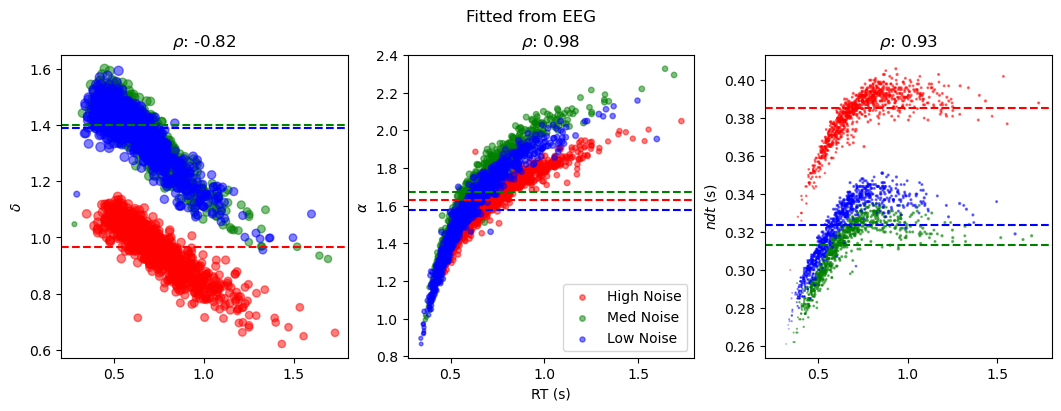

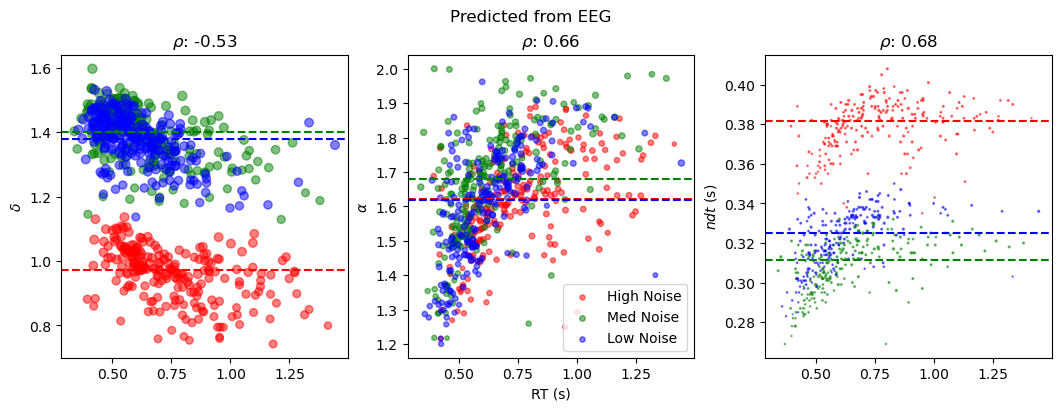

In [22]:
res_ddm_params_eeg, rec_signals_eeg  = get_ddm_n200_results_all('eeg')

sign_rts, sign_v = plot_ddm_params(res_ddm_params_eeg, 'eeg', 'train')
sign_rts, sign_v = plot_ddm_params(res_ddm_params_eeg, 'eeg', 'test')

v, a, ndt - miu 
 -0.78850794 1.8928521 0.3816319
v, a, ndt - sigma 
 [0.06010877 0.06927375 0.01086713]
v, a, ndt - miu 
 -1.3697968 1.2990156 0.29754922
v, a, ndt - sigma 
 [0.04896793 0.07468057 0.00744612]
v, a, ndt - miu 
 -1.3206487 1.5242817 0.32800564
v, a, ndt - sigma 
 [0.05093898 0.06278791 0.00796769]
v, a, ndt - miu 
 -0.7656815 1.9088537 0.39747205
v, a, ndt - sigma 
 [0.06593882 0.0751196  0.011338  ]
v, a, ndt - miu 
 -1.327061 1.6929985 0.3175986
v, a, ndt - sigma 
 [0.05215988 0.0618807  0.00835949]
v, a, ndt - miu 
 -1.3142519 1.5285425 0.3142594
v, a, ndt - sigma 
 [0.05134199 0.06178952 0.00808639]


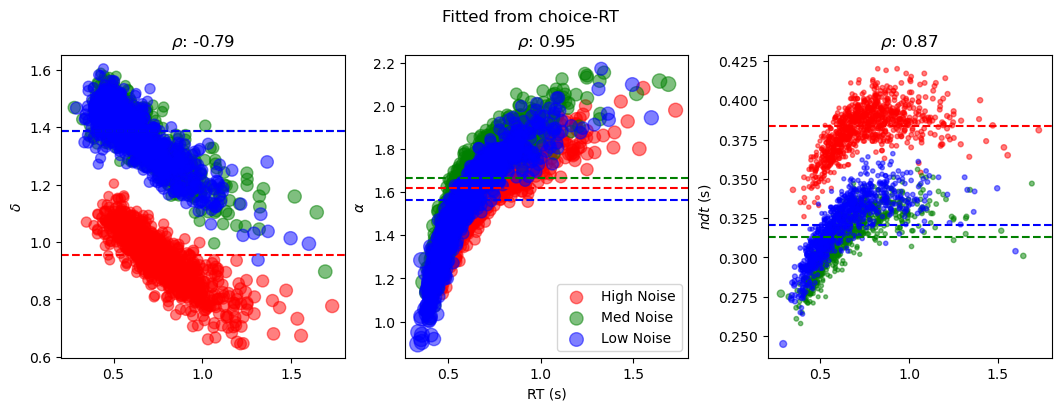

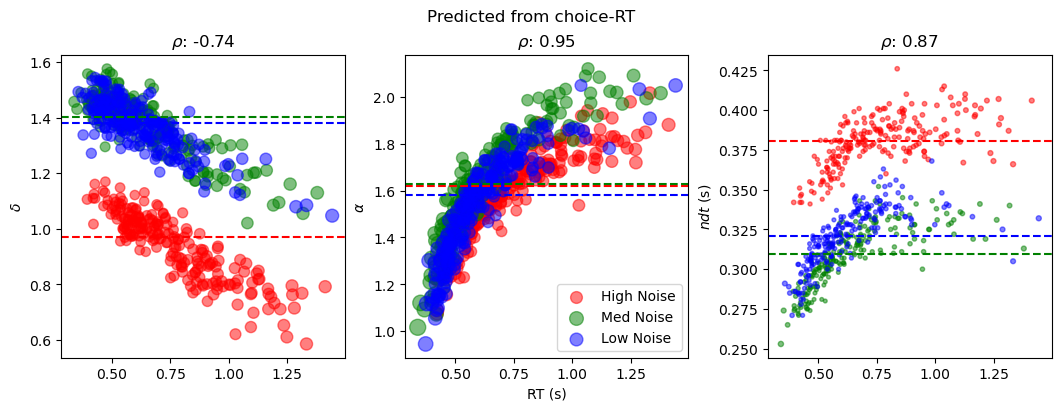

In [24]:
res_ddm_params_rt, rec_signals_rt  = get_ddm_n200_results_all('rt')

sign_rts, sign_v = plot_ddm_params(res_ddm_params_rt, 'rt', 'train')
sign_rts, sign_v = plot_ddm_params(res_ddm_params_rt, 'rt', 'test')

In [25]:
# import pickle

# with open('rec_dict_%s_original.bin' %subject, 'wb') as f:
#     pickle.dump(rec_signals_rt, f)

# with open('rec_dict_%s_gen.bin' %subject, 'wb') as f:
#     pickle.dump(rec_signals_rt, f)

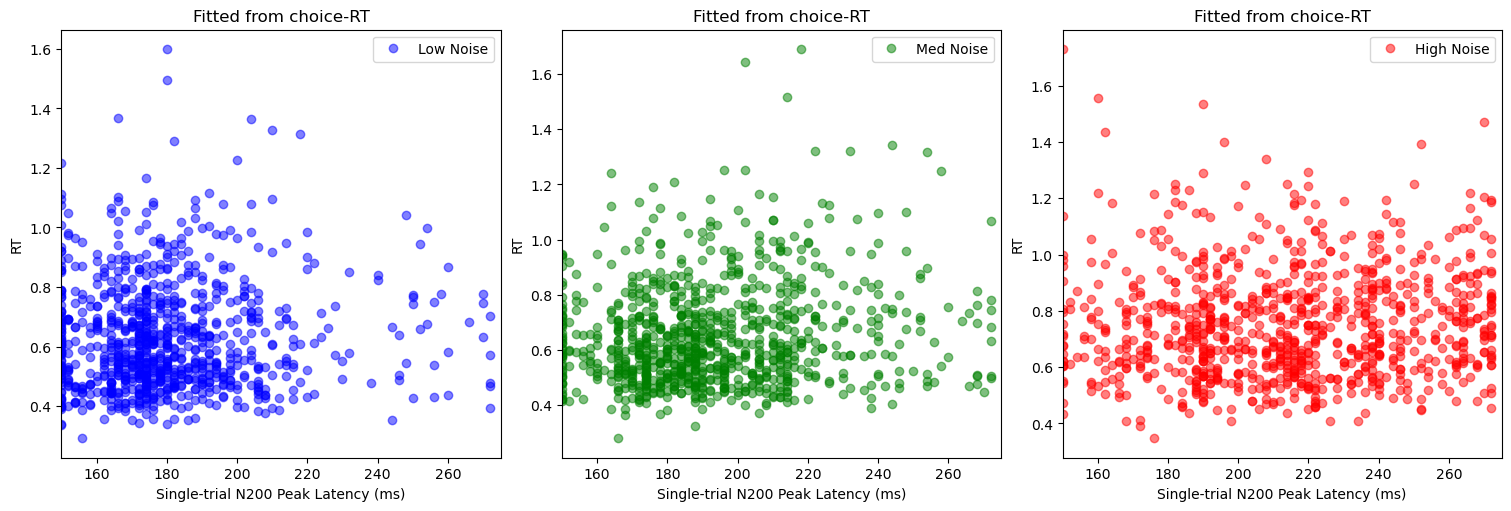

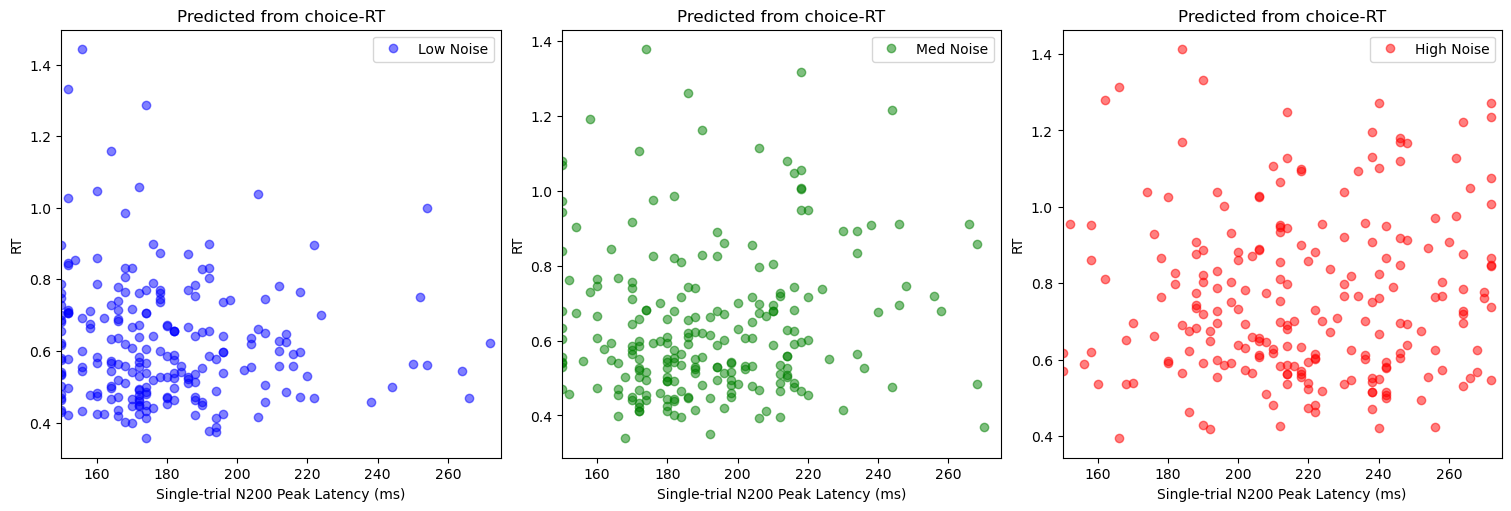

In [26]:
n200_rec_train, n200_ori_train, n200_rec_train_amp, n200_ori_train_amp = plot_scattering_n200(res_ddm_params_rt, 'rt', original=False, train=True)
n200_rec_test, n200_ori_test, n200_rec_test_amp, n200_ori_test_amp = plot_scattering_n200(res_ddm_params_rt, 'rt', original=False, test=True)

(0.0, 0.0192916047203839)


(0.0, 0.0192916047203839)

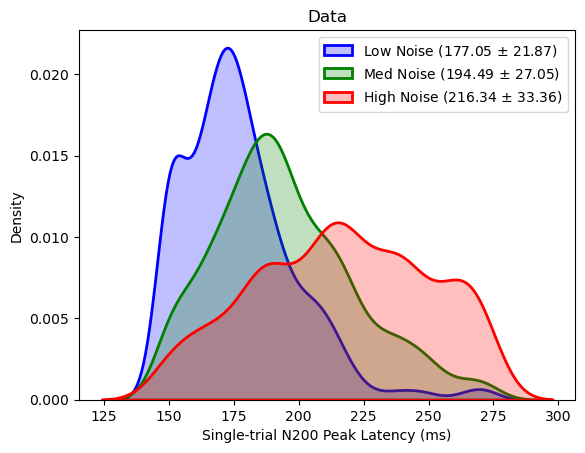

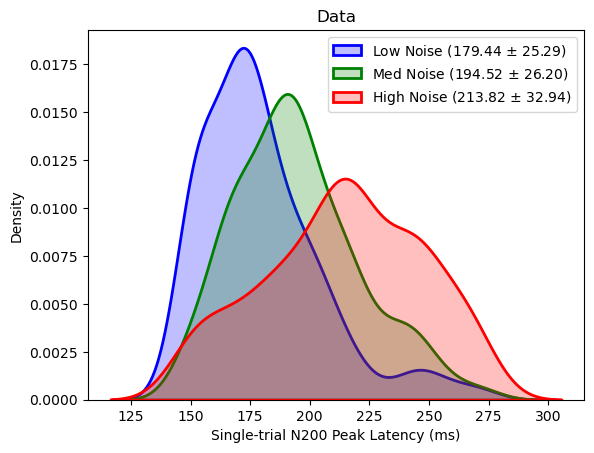

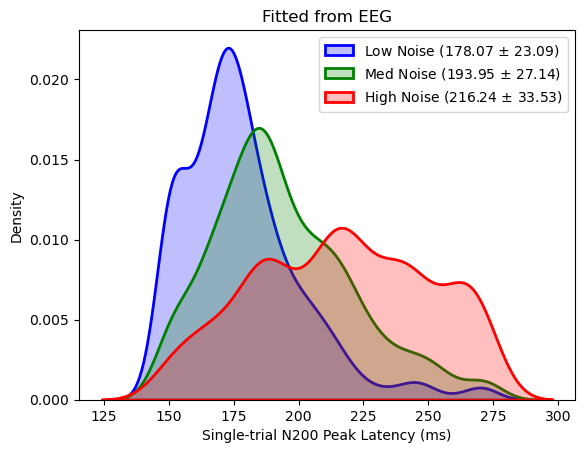

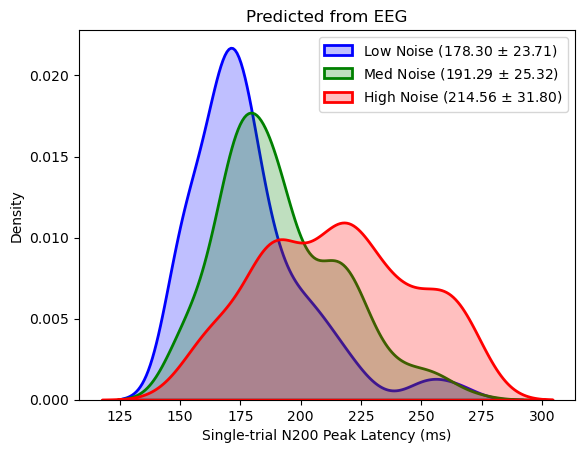

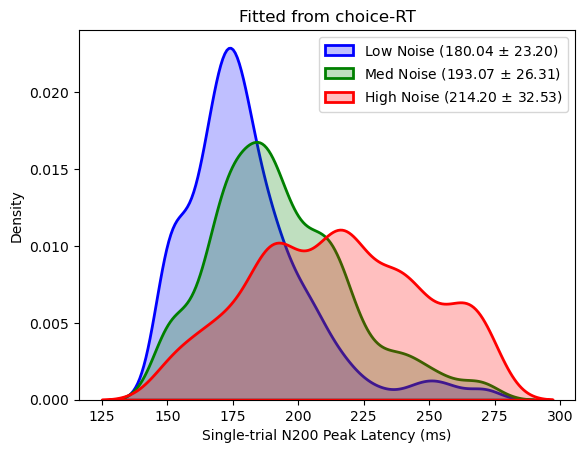

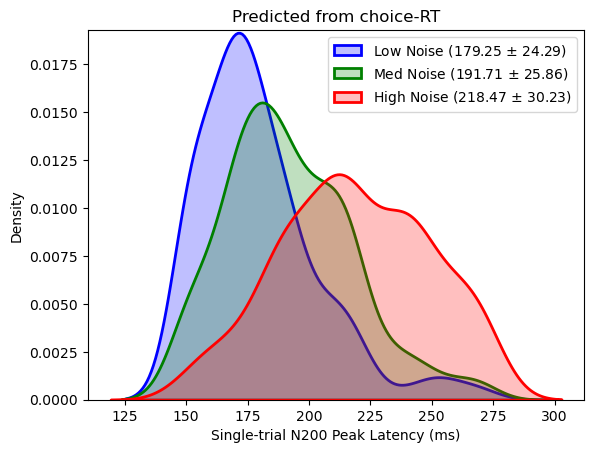

In [27]:
plot_hist_n200(res_ddm_params_eeg, 'eeg', original=True, train=True)
ylim = plot_hist_n200(res_ddm_params_eeg, 'eeg', original=True, test=True)
print(ylim)

plot_hist_n200(res_ddm_params_eeg, 'eeg', original=False, train=True)
plot_hist_n200(res_ddm_params_eeg, 'eeg', original=False, test=True)

plot_hist_n200(res_ddm_params_rt, 'rt', original=False, train=True)
plot_hist_n200(res_ddm_params_rt, 'rt', original=False, test=True, ylim=ylim)

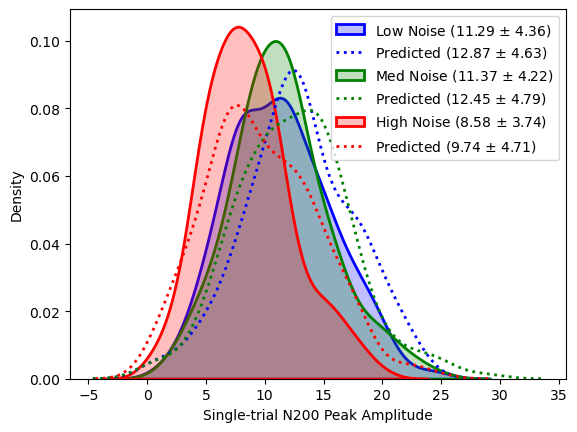

In [28]:
f, ax1 = plt.subplots(1)

sns.distplot(n200_ori_test_amp[0], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 2}, 
                     label = 'Low Noise' + ' (%.2f $\pm$ %.2f)' %(np.mean(n200_ori_test_amp[0]), np.std(n200_ori_test_amp[0])), color='b', ax=ax1)
sns.distplot(n200_rec_test_amp[0], hist = False, kde = True,
                     kde_kws = {'shade': False, 'linewidth': 2, 'linestyle': 'dotted'}, 
                     label = 'Predicted' + ' (%.2f $\pm$ %.2f)' %(np.mean(n200_rec_test_amp[0]), np.std(n200_rec_test_amp[0])), color='b', ax=ax1)

sns.distplot(n200_ori_test_amp[1], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 2}, 
                     label = 'Med Noise' + ' (%.2f $\pm$ %.2f)' %(np.mean(n200_ori_test_amp[1]), np.std(n200_ori_test_amp[1])), color='g', ax=ax1)
sns.distplot(n200_rec_test_amp[1], hist = False, kde = True,
                     kde_kws = {'shade': False, 'linewidth': 2, 'linestyle': 'dotted'}, 
                     label = 'Predicted' + ' (%.2f $\pm$ %.2f)' %(np.mean(n200_rec_test_amp[1]), np.std(n200_rec_test_amp[1])), color='g', ax=ax1)

sns.distplot(n200_ori_test_amp[2], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 2}, 
                     label = 'High Noise' + ' (%.2f $\pm$ %.2f)' %(np.mean(n200_ori_test_amp[2]), np.std(n200_ori_test_amp[2])), color='r', ax=ax1)
sns.distplot(n200_rec_test_amp[2], hist = False, kde = True,
                     kde_kws = {'shade': False, 'linewidth': 2, 'linestyle': 'dotted'}, 
                     label = 'Predicted' + ' (%.2f $\pm$ %.2f)' %(np.mean(n200_rec_test_amp[2]), np.std(n200_rec_test_amp[2])), color='r', ax=ax1)

ax1.set_xlabel('Single-trial N200 Peak Amplitude')
ax1.set_ylabel('Density')

ax1.legend(loc='upper right')
# plt.savefig('saved_results/%s/%s/%s.png' %(subject, cond, 'n200_amp2'), dpi=400)

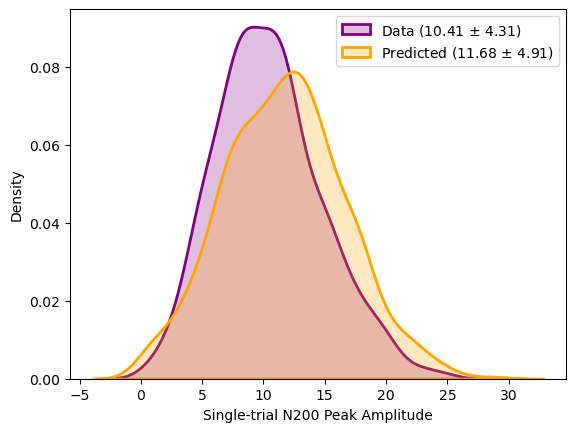

In [29]:
f, ax1 = plt.subplots(1)

n200_ori_test_amp = np.concatenate(n200_ori_test_amp)
n200_rec_test_amp = np.concatenate(n200_rec_test_amp)

sns.distplot(n200_ori_test_amp, hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 2}, 
                     label = 'Data' + ' (%.2f $\pm$ %.2f)' %(np.mean(n200_ori_test_amp), np.std(n200_ori_test_amp)), color='purple', ax=ax1)
sns.distplot(n200_rec_test_amp, hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 2}, 
                     label = 'Predicted' + ' (%.2f $\pm$ %.2f)' %(np.mean(n200_rec_test_amp), np.std(n200_rec_test_amp)), color='orange', ax=ax1)

ax1.set_xlabel('Single-trial N200 Peak Amplitude')
ax1.set_ylabel('Density')

ax1.legend(loc='upper right')
# plt.savefig('saved_results/%s/%s/%s.png' %(subject, cond, 'n200_amp2'), dpi=400)

# Likelihood

In [30]:
median_v, median_a, median_ndt = calc_nllh(res_ddm_params_rt, 'train')
calc_nllh(res_ddm_params_rt, 'test', median_v, median_a, median_ndt)

train
-1.3099823 1.621213 0.3297807
nllh -0.04
nllh priors -1.964
nllh_median 0.222
test
-1.3198135 1.6066216 0.32945678
nllh -0.05
nllh priors -1.992
nllh_median 0.219
nllh_median2 0.226


In [31]:
median_v, median_a, median_ndt = calc_nllh(res_ddm_params_eeg, 'train')
calc_nllh(res_ddm_params_eeg, 'test', median_v, median_a, median_ndt)

train
-1.3091762 1.629528 0.32894057
nllh 0.049
nllh priors -1.964
nllh_median 0.223
test
-1.3273574 1.6352677 0.32750803
nllh 0.202
nllh priors -1.992
nllh_median 0.224
nllh_median2 0.226


# SSVEP

30 Hz 7.214861596231222
40 Hz 4.66726592320261
Peak at (184, 1.159771549306057)


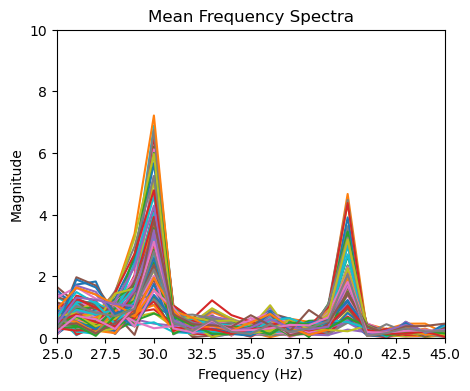

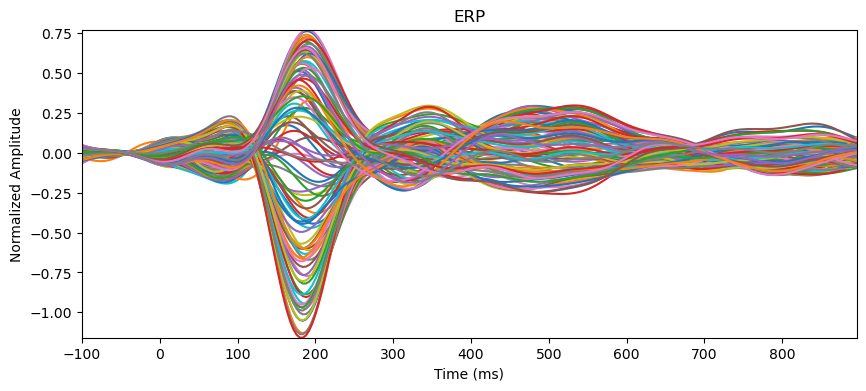

In [32]:
eeg_all_ori = generate_eeg_from_rt(test_dataloader, original_eeg=True)
plot_fft_channels(eeg_all_ori, ylim=10)
eeg_all = low_pass_erp(eeg_all_ori)
plot_erp(eeg_all)
print('Peak at', get_min_peak(eeg_all))

30 Hz 5.9665148865268645
40 Hz 4.0674191426398565
Peak at (184, 1.1881402172972155)


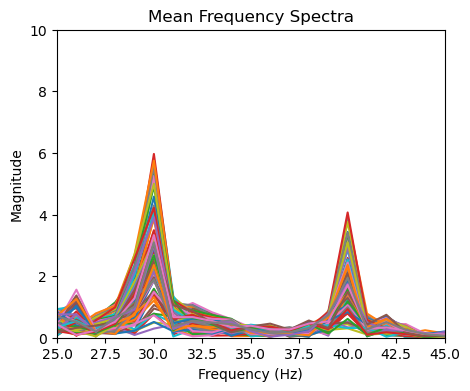

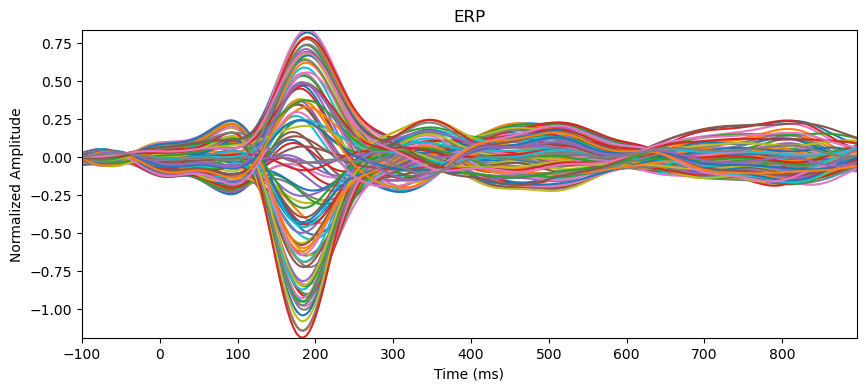

In [33]:
eeg_all_rec = generate_eeg_from_rt(test_dataloader, original_eeg=False)
plot_fft_channels(eeg_all_rec, ylim=10)
eeg_all = low_pass_erp(eeg_all_rec)
plot_erp(eeg_all)
print('Peak at', get_min_peak(eeg_all))

30 Hz 8.541260564631061
40 Hz 6.206149759659834
Peak at (188, 1.4407685845040752)


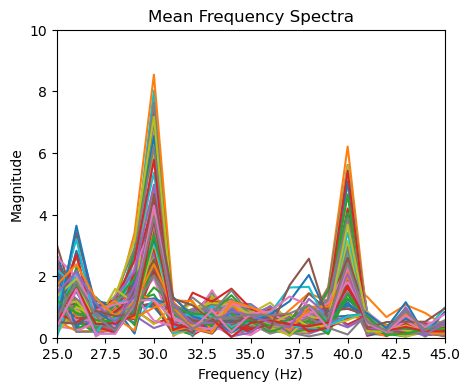

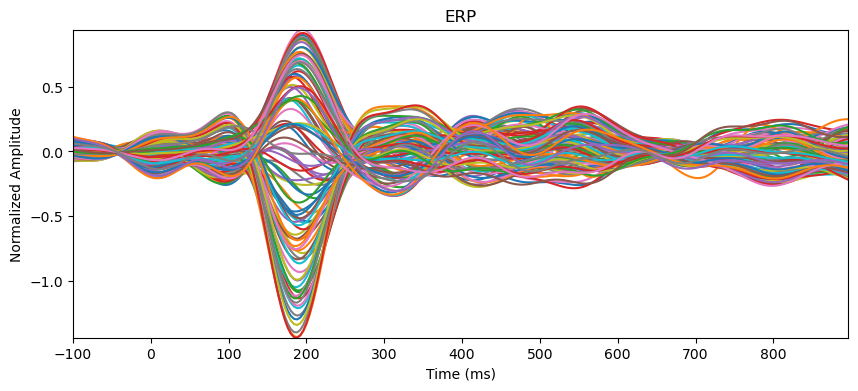

In [34]:
eeg_all = generate_eeg_from_rt(test_dataloader, original_eeg=True, cond_of_interest=med_cond)
plot_fft_channels(eeg_all, ylim=10)
eeg_all = low_pass_erp(eeg_all)
plot_erp(eeg_all)
print('Peak at', get_min_peak(eeg_all))

30 Hz 7.095560840636595
40 Hz 3.988510895050035
Peak at (184, 1.4687041059358201)


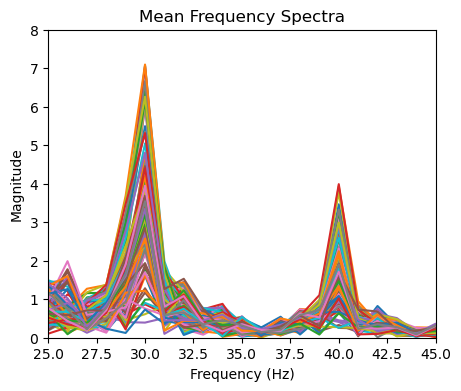

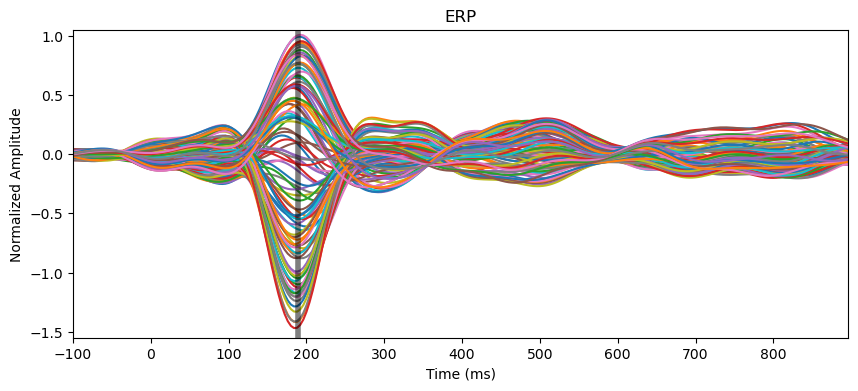

In [35]:
eeg_all = generate_eeg_from_rt(test_dataloader, original_eeg=False, cond_of_interest=med_cond)
plot_fft_channels(eeg_all, ylim=8)
eeg_all = low_pass_erp(eeg_all)
plot_erp(eeg_all, ylim=(-1.55, 1.05), n200_loc=188)
print('Peak at', get_min_peak(eeg_all))

30 Hz 9.69902062995565
40 Hz 3.42854658144305
Peak at (168, 1.6731480034226844)


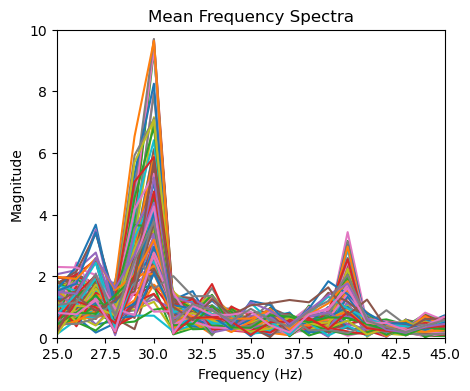

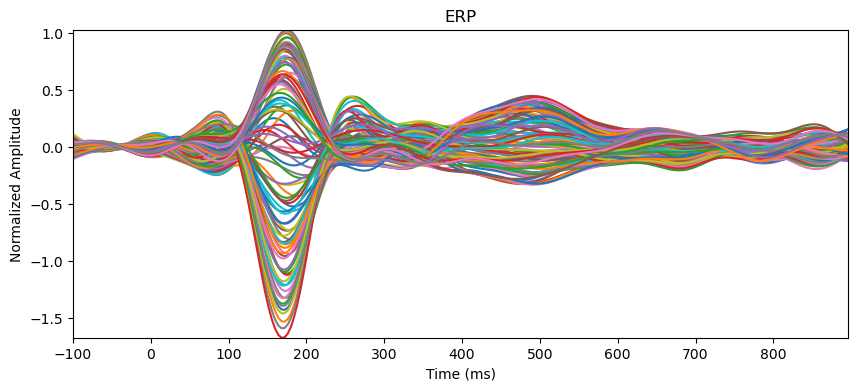

In [36]:
eeg_all = generate_eeg_from_rt(test_dataloader, original_eeg=True, cond_of_interest=high_cond)
plot_fft_channels(eeg_all, ylim=10)
eeg_all = low_pass_erp(eeg_all)
plot_erp(eeg_all)
print('Peak at', get_min_peak(eeg_all))

30 Hz 7.595588438724682
40 Hz 2.2758415901215208
Peak at (172, 1.6574174416235476)


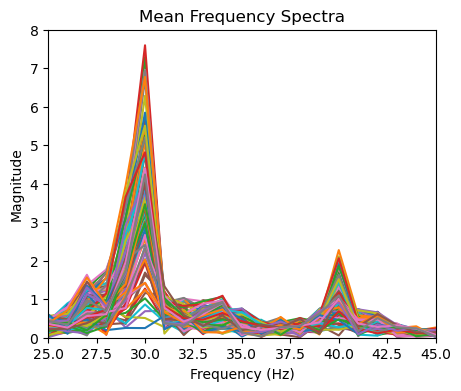

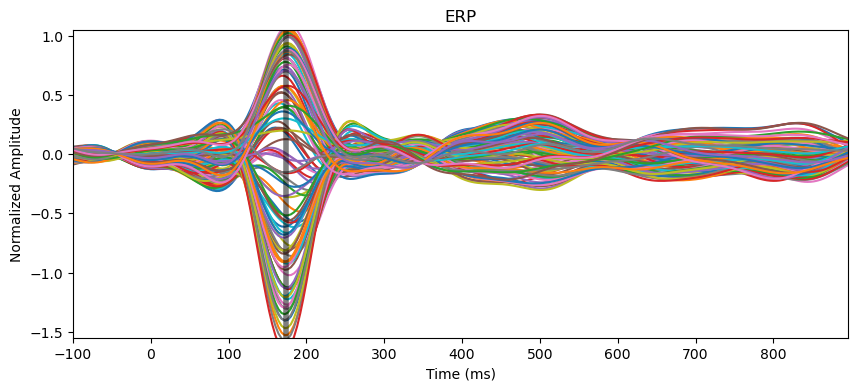

In [37]:
eeg_all = generate_eeg_from_rt(test_dataloader, original_eeg=False, cond_of_interest=high_cond)
plot_fft_channels(eeg_all, ylim=8)
eeg_all = low_pass_erp(eeg_all)
plot_erp(eeg_all, ylim=(-1.55, 1.05), n200_loc=172)
print('Peak at', get_min_peak(eeg_all))

30 Hz 4.17648558925097
40 Hz 9.029934861195153
Peak at (216, 0.8598972810709248)


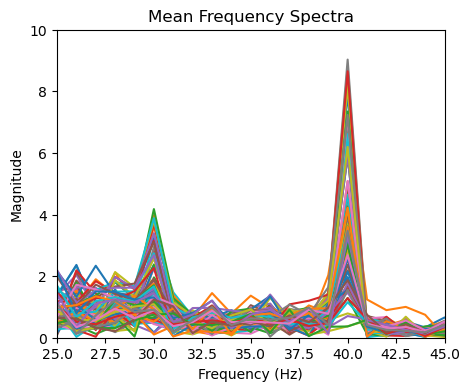

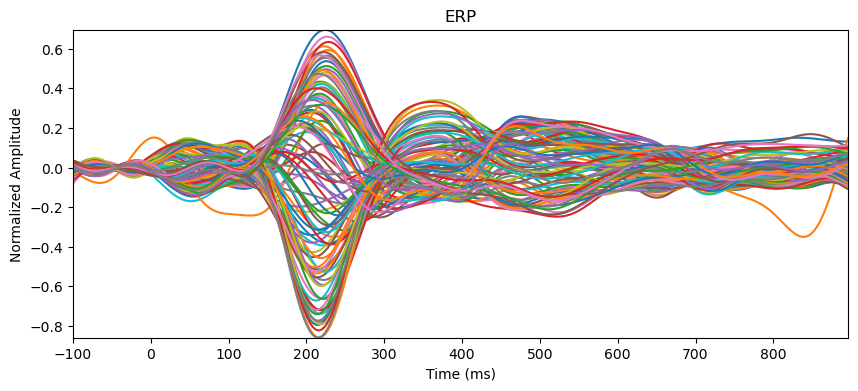

In [38]:
eeg_all = generate_eeg_from_rt(test_dataloader, original_eeg=True, cond_of_interest=low_cond)
plot_fft_channels(eeg_all, ylim=10)
eeg_all = low_pass_erp(eeg_all)
plot_erp(eeg_all)
print('Peak at', get_min_peak(eeg_all))

30 Hz 3.4894903687142884
40 Hz 7.341064131811313
Peak at (216, 0.8379733785325201)


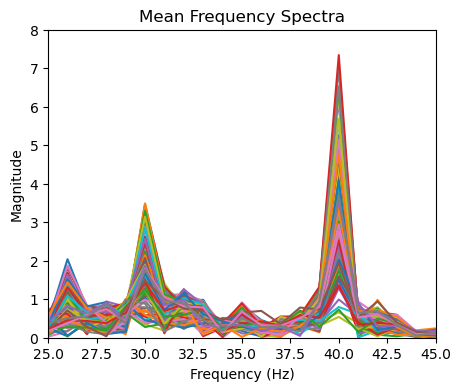

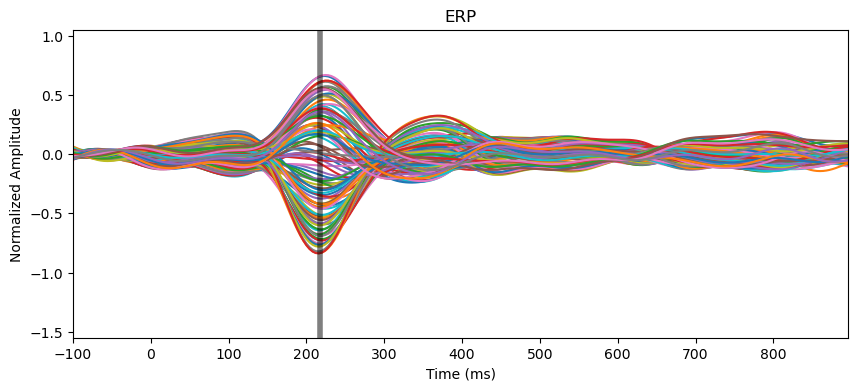

In [39]:
eeg_all_rec = generate_eeg_from_rt(test_dataloader, original_eeg=False, cond_of_interest=low_cond)
plot_fft_channels(eeg_all_rec, ylim=8)
eeg_all = low_pass_erp(eeg_all_rec)
plot_erp(eeg_all, ylim=(-1.55, 1.05), n200_loc=216)
print('Peak at', get_min_peak(eeg_all))

# RT Sensivity

In [40]:
# dataloader_ = train_dataloader
dataloader_ = test_dataloader

In [41]:
hz_30_energies, hz_40_energies = [], []
n200_idx = []
n200_amp = []
xticks = []

for rts in np.arange(0, 1.2, 0.2):
    time_range = "{:.1f}-{:.1f}".format(rts, rts+0.2)
    print('time range', time_range)
    try:
        eeg_all = generate_eeg_from_rt(dataloader_, rts_low=rts, rts_high=rts+0.2)
        hz_30, hz_40 = plot_fft_channels(eeg_all, power_only=True)
        hz_30_energies.append(hz_30); hz_40_energies.append(hz_40)
        eeg_all = low_pass_erp(eeg_all)
        min_peak_idx, min_peak_amp = get_min_peak(eeg_all)
        n200_idx.append(min_peak_idx)
        n200_amp.append(min_peak_amp)
        xticks.append(time_range)
    except RuntimeError:
        print('No data')

time range 0.0-0.2
No data
time range 0.2-0.4
30 Hz 7.8149409074478955
40 Hz 3.7923880361587963
time range 0.4-0.6
30 Hz 6.876110224118096
40 Hz 3.5424499043075452
time range 0.6-0.8
30 Hz 5.77724456872203
40 Hz 4.123767643524017
time range 0.8-1.0
30 Hz 4.87283288140284
40 Hz 5.188921811687213
time range 1.0-1.2
30 Hz 4.992083829357622
40 Hz 5.113573371200137


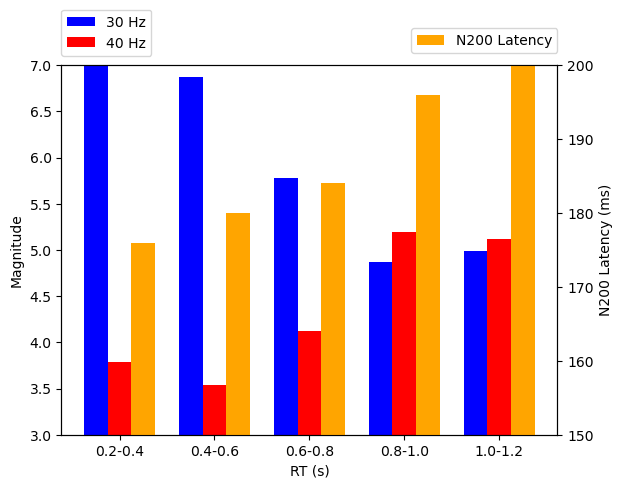

In [42]:
barWidth = 0.25

br1 = np.arange(len(xticks))
br2 = [x + barWidth for x in br1]
br3 = [x + 2 * barWidth for x in br1]

fig, ax1 = plt.subplots()

ax1.bar(br1, hz_30_energies, color='b', width = barWidth, label='30 Hz')
ax1.bar(br2, hz_40_energies, color='r', width = barWidth, label='40 Hz')
ax1.set_ylim(3, 7.0)
ax1.set_xlabel('RT (s)')
ax1.set_ylabel('Magnitude')
ax1.legend(bbox_to_anchor=(0, 1.15), loc='upper left', borderaxespad=0)

ax2 = ax1.twinx()
ax2.bar(br3, n200_idx, color='orange', width = barWidth, label='N200 Latency')
ax2.set_ylim(150, 200)
ax2.set_ylabel('N200 Latency (ms)')
ax2.set_xticks([x + barWidth for x in br1], xticks, rotation='horizontal')
ax2.legend(bbox_to_anchor=(0.705, 1.1), loc='upper left', borderaxespad=0)

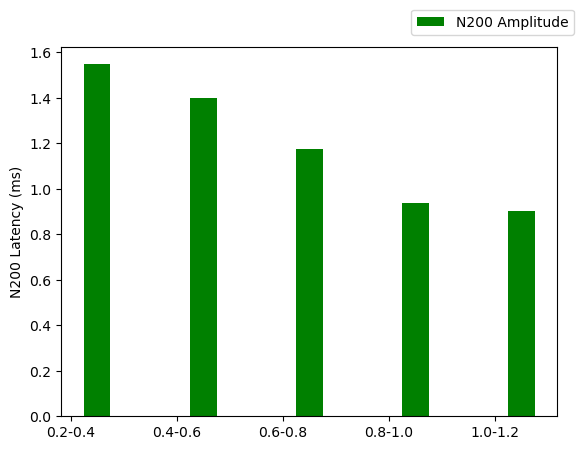

In [43]:
fig, ax3 = plt.subplots()

ax3.bar(br3, n200_amp, color='g', width = barWidth, label='N200 Amplitude')
# ax3.set_ylim(150, 200)
ax3.set_ylabel('N200 Latency (ms)')
ax3.set_xticks([x + barWidth for x in br1], xticks, rotation='horizontal')
ax3.legend(bbox_to_anchor=(0.705, 1.1), loc='upper left', borderaxespad=0)

# DDM Sensitivity

In [44]:
dataloader_ = test_dataloader

colors = ['b', 'g', 'r']
# set_seed(2859)

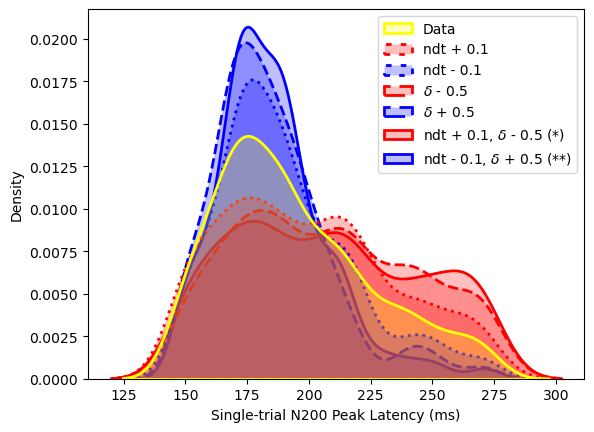

In [60]:
ndt_diff = 0.1
v_diff = 0.5

# n200_latencies, eeg_rec1 = vary_ddm_params(dataloader_, ndt=ndt_diff, v=v_diff, diff=True, cond_of_interest=low_cond)
# sns.distplot(n200_latencies, hist=False, kde=True,
#                  kde_kws={'shade': True, 'linewidth': 2, 'color': 'r'}, label=r'(2), High Noise')
# n200_latencies, eeg_rec3 = vary_ddm_params(dataloader_, ndt=-ndt_diff, v=-v_diff, diff=True, cond_of_interest=high_cond)
# sns.distplot(n200_latencies, hist=False, kde=True,
#                  kde_kws={'shade': True, 'linewidth': 2, 'color': 'b'}, label=r'(1), Low Noise')

n200_latencies, n200_amplitudes1, eeg_rec1 = vary_ddm_params(dataloader_, ndt=-ndt_diff, v=-v_diff, diff=True)
sns.distplot(n200_latencies, hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 2, 'color': 'b'}, label=r'ndt - %s, $\delta$ + %s (**)' %(ndt_diff, v_diff))
n200_latencies, n200_amplitudes2, eeg_rec2 = vary_ddm_params(dataloader_, ndt=ndt_diff, v=v_diff, diff=True)
sns.distplot(n200_latencies, hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 2, 'color': 'r'}, label=r'ndt + %s, $\delta$ - %s (*)' %(ndt_diff, v_diff))

n200_latencies, n200_amplitudes3, eeg_rec3 = vary_ddm_params(dataloader_, v=-v_diff, diff=True)
sns.distplot(n200_latencies, hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 2, 'linestyle':'--', 'color': 'b'}, label=r'$\delta$ + %s' %(v_diff))
n200_latencies, n200_amplitudes4, eeg_rec4 = vary_ddm_params(dataloader_, v=v_diff, diff=True)
sns.distplot(n200_latencies, hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 2, 'linestyle':'--', 'color': 'r'}, label=r'$\delta$ - %s' %(v_diff))

n200_latencies, n200_amplitudes5, eeg_rec5 = vary_ddm_params(dataloader_, ndt=-ndt_diff, diff=True)
sns.distplot(n200_latencies, hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 2, 'linestyle':'dotted', 'color': 'b'}, label=r'ndt - %s' %(ndt_diff))
n200_latencies, n200_amplitudes6, eeg_rec6 = vary_ddm_params(dataloader_, ndt=ndt_diff, diff=True)
sns.distplot(n200_latencies, hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 2, 'linestyle':'dotted', 'color': 'r'}, label=r'ndt + %s' %(ndt_diff))

n200_latencies, n200_amplitudes7, eeg_rec7 = vary_ddm_params(dataloader_, ndt=0, v=0, diff=True)
sns.distplot(n200_latencies, hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 2, 'color': 'yellow'}, label = 'Data')

plt.xlabel('Single-trial N200 Peak Latency (ms)')
plt.ylabel('Density')
plt.legend(loc='upper right', reverse=True)

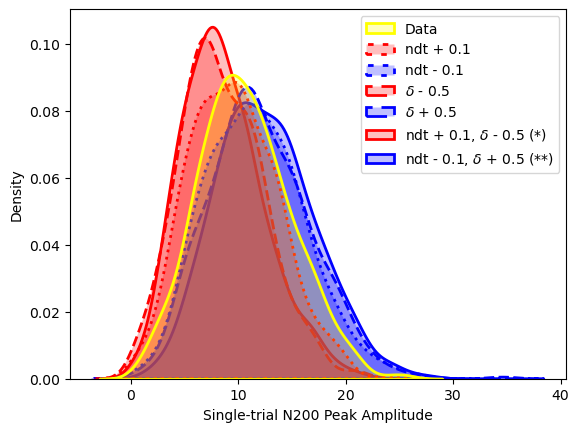

In [46]:
sns.distplot(n200_amplitudes1, hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 2, 'color': 'b'}, label=r'ndt - %s, $\delta$ + %s (**)' %(ndt_diff, v_diff))
sns.distplot(n200_amplitudes2, hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 2, 'color': 'r'}, label=r'ndt + %s, $\delta$ - %s (*)' %(ndt_diff, v_diff))

sns.distplot(n200_amplitudes3, hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 2, 'linestyle':'--', 'color': 'b'}, label=r'$\delta$ + %s' %(v_diff))
sns.distplot(n200_amplitudes4, hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 2, 'linestyle':'--', 'color': 'r'}, label=r'$\delta$ - %s' %(v_diff))

sns.distplot(n200_amplitudes5, hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 2, 'linestyle':'dotted', 'color': 'b'}, label=r'ndt - %s' %(ndt_diff))
sns.distplot(n200_amplitudes6, hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 2, 'linestyle':'dotted', 'color': 'r'}, label=r'ndt + %s' %(ndt_diff))

sns.distplot(n200_amplitudes7, hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 2, 'color': 'yellow'}, label = 'Data')

plt.xlabel('Single-trial N200 Peak Amplitude')
plt.ylabel('Density')
plt.legend(loc='upper right', reverse=True)

In [47]:
hz_30_energies, hz_40_energies = [], []
hz_30, hz_40 = plot_fft_channels(eeg_rec1, power_only=True)
hz_30_energies.append(hz_30); hz_40_energies.append(hz_40)
hz_30, hz_40 = plot_fft_channels(eeg_rec2, power_only=True)
hz_30_energies.append(hz_30); hz_40_energies.append(hz_40)
hz_30, hz_40 = plot_fft_channels(eeg_rec3, power_only=True)
hz_30_energies.append(hz_30); hz_40_energies.append(hz_40)
hz_30, hz_40 = plot_fft_channels(eeg_rec4, power_only=True)
hz_30_energies.append(hz_30); hz_40_energies.append(hz_40)
hz_30, hz_40 = plot_fft_channels(eeg_rec5, power_only=True)
hz_30_energies.append(hz_30); hz_40_energies.append(hz_40)
hz_30, hz_40 = plot_fft_channels(eeg_rec6, power_only=True)
hz_30_energies.append(hz_30); hz_40_energies.append(hz_40)
hz_30, hz_40 = plot_fft_channels(eeg_rec7, power_only=True)
hz_30_energies.append(hz_30); hz_40_energies.append(hz_40)
hz_30_energies.reverse()
hz_40_energies.reverse()

30 Hz 7.60055873056907
40 Hz 3.7276441431732685
30 Hz 3.960927716368548
40 Hz 4.83717035680795
30 Hz 7.257266489623474
40 Hz 3.982841603838227
30 Hz 4.659632278954516
40 Hz 4.7685003781208115
30 Hz 6.522886243661623
40 Hz 3.702753470779191
30 Hz 5.361714834980283
40 Hz 4.001006693007292
30 Hz 6.0622897964180655
40 Hz 4.209909595964334


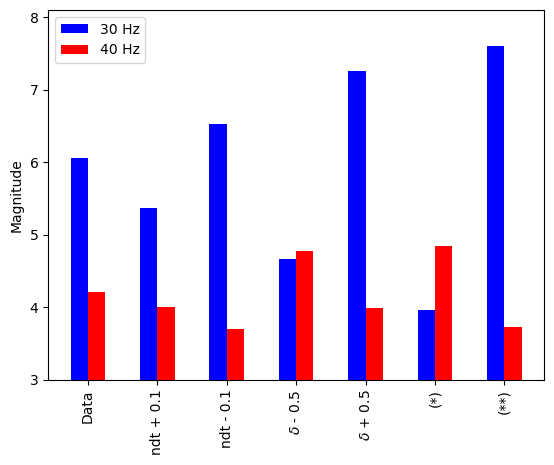

In [48]:
barWidth = 0.25

br1 = [0, 1, 2, 3, 4, 5, 6]
br2 = [x + barWidth for x in br1]

fig, ax = plt.subplots()

bar_container1 = ax.bar(br1, hz_30_energies, color='b', width = barWidth, label='30 Hz')
bar_container2 = ax.bar(br2, hz_40_energies, color='r', width = barWidth, label='40 Hz')

ax.set_ylim(3, 8.1)
ax.set_ylabel('Magnitude')
ax.set_xticks([x + barWidth / 2 for x in br1], ['Data', r'ndt + %s' %(ndt_diff), r'ndt - %s' %(ndt_diff), \
                                                r'$\delta$ - %s' %(v_diff), r'$\delta$ + %s' %(v_diff), \
                                                    '(*)', '(**)'], rotation='vertical')
# ax.bar_label(bar_container1)
# ax.bar_label(bar_container2)
ax.legend(loc='upper left')